In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from skimage.morphology import medial_axis 
from skimage.util import invert
import numpy.linalg as LA
import pkg_resources 
pkg_resources.require("networkx==2.1") 
import networkx as nx

%matplotlib inline 
plt.rcParams['figure.figsize'] = 20, 10

In [2]:
filename = '../colliders.csv'
data = np.loadtxt(filename,delimiter=',',dtype='Float64',skiprows=2)
# print(data)

In [3]:
import os, sys
from udacidrone.frame_utils import global_to_local, local_to_global

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('planning_utils.py'))))
from planning_utils import create_grid, a_star, heuristic, read_global_home
from planning_utils import find_start_goal, create_grid_and_edges, closest_point

In [4]:
# global_home = np.array([-122.39745, 37.79248, 0.0])
global_home = read_global_home(filename)
print(f'Global Home     => [lon, lat]   : {global_home}')

TARGET_ALTITUDE = 5
SAFETY_DISTANCE = 5

# testcase1
# lon0=-122.399505
# lat0=37.790714

s_lon0,s_lat0 = global_home[0], global_home[1]  #take off from map center
# s_lon0, s_lat0 =-122.402224, 37.797330   #failed
# s_lon0, s_lat0 =-122.400128, 37.790983
# s_lon0, s_lat0 =-122.400336, 37.792173
# s_lon0, s_lat0 =-122.394358, 37.791702

grid, edges = create_grid_and_edges(data, TARGET_ALTITUDE, SAFETY_DISTANCE)
print('Found %5d edges' % len(edges))

Global Home     => [lon, lat]   : [-122.39745   37.79248]
-316.0 605.0
-445.0 476.0
921 921
Found  1055 edges


In [5]:
# grid_start = (232, 718)
local_start = (316, 445)
local_goal = (716, 845)
# local_goal = (750., 370.)

# skeleton = medial_axis(invert(grid))
# skel_start, skel_goal = find_start_goal(skeleton, local_start, local_goal)

print(local_start, local_goal)
# print(skel_start, skel_goal)

(316, 445) (716, 845)


In [6]:
# g_lon0,g_lat0 =-122.402224, 37.797330 

# north, east = -north_offset + 400, -east_offset + 400
# grid_goal = (north, east)
# print(f'Grid goal : {grid_goal}')

In [7]:
# def visualize_path(g_start, g_goal, g, waypoints):
#     """
#     Visualize the path to get from `g_start` to `g_goal` defined by `waypoints` and the grid `g`
#     """
# #     path, cost = a_star(g, heuristic, grid_start, grid_goal)
# #     print(f'Path cost: {cost}')
    
# #     waypoints = np.array([[p[0] + n_offset, p[1] + e_offset, TARGET_ALTITUDE, 0] for p in path])
# #     print(f'Waypoint count : {waypoints.shape[0]}')
    
#     fig = plt.figure(figsize=(20,10))   
#     plt.imshow(g, origin='lower') 

#     plt.plot(waypoints[:, 1], waypoints[:, 0], 'g')    
#     plt.plot(waypoints[:, 1], waypoints[:, 0], 'oc')
#     plt.plot(g_start[1], g_start[0], 'r+')    
#     plt.plot(g_goal[1], g_goal[0], 'r+')


#     plt.xlabel('EAST')
#     plt.ylabel('NORTH')
#     plt.show()

In [10]:

# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()
for e in edges:
    p1 = e[0]
    p2 = e[1]
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

In [11]:
local_start_g = closest_point(G, local_start)
local_goal_g = closest_point(G, local_goal)

print(local_start)
print(local_goal)
print(local_start_g)
print(local_goal_g)

(316, 445)
(716, 845)
(315.76114, 445.76846)
(692.4618578581275, 822.4692578581274)


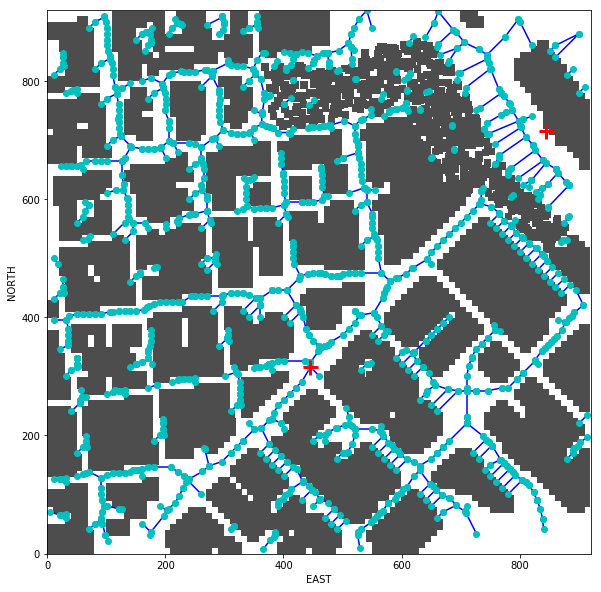

In [8]:
plt.rcParams['figure.figsize'] = 20, 10

# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys', alpha=0.7) 
# plt.imshow(skeleton, cmap='Greys', origin='lower', alpha=0.7)

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'oc')    

plt.plot(local_start[1], local_start[0], 'r+', ms=15, mew=3)    
plt.plot(local_goal[1], local_goal[0], 'r+', ms=15, mew=3)

plt.xlabel('EAST')
plt.ylabel('NORTH') 
plt.show()

In [12]:
# Use A* to compute the path.
path, cost = a_star(G, heuristic, local_start_g, local_goal_g)
print(len(path))

*************************************************
Failed to find a path!
*************************************************
0


In [36]:
print(nx.is_connected(G))
print("Number of subgraph : {}".format(nx.number_connected_components(G)))
# x = [G.subgraph(c) for c in nx.connected_components(G)]

False
Number of subgraph : 75


In [65]:
subgraphs = list(nx.connected_component_subgraphs(G, copy=False))

for i, sg in enumerate(subgraphs):
    if sg.number_of_nodes() > 50 and nx.is_connected(sg):
        print('id: {}, #nodes: {}, #edges：{}'.format(i, sg.number_of_nodes(), sg.number_of_edges()))

id: 2, #nodes: 84, #edges：83
id: 3, #nodes: 163, #edges：162
id: 4, #nodes: 179, #edges：180
id: 13, #nodes: 293, #edges：293


In [62]:
# nx.compose(subgraphs[13], subgraphs[4]).number_of_nodes()
G2 = nx.Graph()
# G2.add_edges_from(subgraphs[4])
# G2.add_edges_from(subgraphs[13])
G2.add_edges_from(subgraphs[3])
G2.add_nodes_from(subgraphs[3])
# G2.number_of_nodes()
# G2.number_of_edges()
print(nx.is_connected(G2))

False


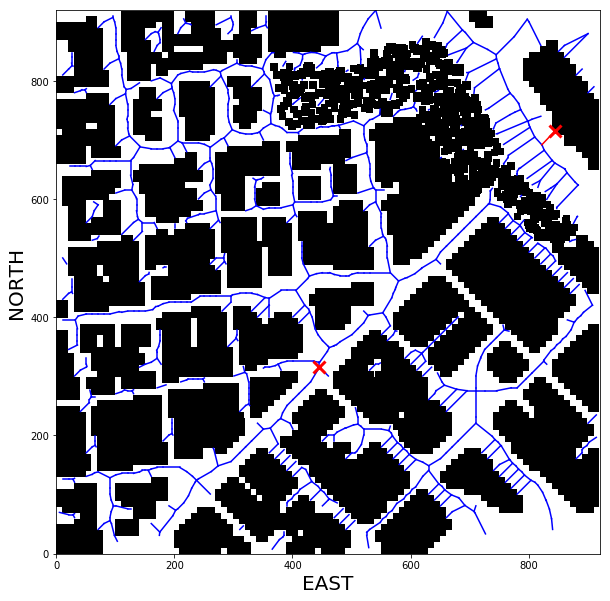

In [13]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.plot([local_start[1], local_start_g[1]], [local_start[0], local_start_g[0]], 'r-')

for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'g-')
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'oc')
    
plt.plot([local_goal[1], local_goal_g[1]], [local_goal[0], local_goal_g[0]], 'r-')

# marker="o",  markersize=10
# plt.plot(local_start[1], local_start[0], 'gx')
# plt.plot(local_goal[1], local_goal[0], 'gx')

plt.plot(local_start[1], local_start[0], 'rx',  mew=3, ms=12)
plt.plot(local_goal[1], local_goal[0], 'rx',   mew=3, ms=12)


plt.xlabel('EAST', fontsize=20)
plt.ylabel('NORTH', fontsize=20)
plt.show()

#### Path Pruning

In [14]:
# pruned_path = prune_path(path)
# print(len(pruned_path))

# pruned_waypoints =  np.array([[p[0] , p[1] , TARGET_ALTITUDE, 0] for p in pruned_path])

# visualize_path(grid_start, grid_goal, grid, pruned_waypoints)